<a href="https://colab.research.google.com/github/mssabahi/Machine_Learning/blob/master/Trading_System_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

(Reading database ... 155073 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) over (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link



## DATA CREATION 

### Importing Libraries

First, we will import the SVC class which will be used later to instantiate a support vector classifier.

In [2]:
from sklearn.svm import SVC
from sklearn.metrics import plot_confusion_matrix 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
# from fwTimeSeriesSplit import fwTimeSeriesSplit
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import talib as ta
import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

### Importing Data (Open-High-Low-Close-Volume)

We will upload the data and save it in a Dataframe named as ‘Df’
To upload we use "pandas.read_csv("NSE_cash.csv")".
Our data is a 10 minute OHLCV data for the data. 


In [3]:
df = pd.read_csv('data.csv') 
df = df[['Time','Open','High','Low','Close','Volume']]

In [4]:
df.head()

,Time,Open,High,Low,Close,Volume
0,09:15:59,319.25,319.40,316.05,317.70,143354
1,09:16:59,317.70,318.20,317.70,318.00,52695
2,09:17:59,318.00,318.85,318.00,318.55,47179
3,09:18:59,318.65,319.40,318.50,319.20,44745
4,09:19:59,319.30,319.85,319.20,319.65,57892


We will drop all rows which have no traded volume. This is done to avoid training on low liquidity moves. Alternatively, we can drop all those rows where volume is less than some value we know beforehand.


In [5]:
df = df.drop(df[df['Volume']==0].index)
df.dropna(inplace=True)

Now, we shoul change the Time column to a ‘datetime’ type. 

In [6]:
df['Time'] = pd.to_datetime(df['Time'])

In [7]:
df.head()

,Time,Open,High,Low,Close,Volume
0,2021-10-18 09:15:59,319.25,319.40,316.05,317.70,143354
1,2021-10-18 09:16:59,317.70,318.20,317.70,318.00,52695
2,2021-10-18 09:17:59,318.00,318.85,318.00,318.55,47179
3,2021-10-18 09:18:59,318.65,319.40,318.50,319.20,44745
4,2021-10-18 09:19:59,319.30,319.85,319.20,319.65,57892


In [8]:
df.shape

(750, 6)

### Splitting Data

We will use 80% of our data to train and the rest 20% to test. To do this, we will create a split parameter which will divide the dataframe in an 80-20 ratio. It is advisable to give at least 70% data as train data for good results. "split" is the integer index value for the row corresponding to test-train split. 

In [9]:
t = 0.8
split = int(t*len(df))

In [10]:
split

600

### Creating Indicators

Next, we decide the time period for which we will calculate our indicators. For this, we chose a variable ‘n’ with a value of 6 half hours. This is something we can change as per our choice. We will be creating all the indicators for the same time period. 


Lookback window

In [11]:
n = 10 #This is the window for return periods (among other things)

Next, we will create RSI and some other indicators. As you can see in the ‘RSI’ calculation below, two things are being done. First, the “Close” prices column is ‘shifted’ down by a single time interval, one minute, in our case. This is done so that we work on historical data. Secondly, “timeperiod” is chosen as “n” which we earlier defined as ‘6’ half hours. So if we are calculating RSI for ‘t’th half hour, we will use Closing prices of ‘t-10’, ‘t-9’, …’t-1’ half hours.) 


### The indicators used for this system:
* **RSI**
> The relative strength index (RSI) provides technical traders with signals about bullish and bearish price momentum, and it is often plotted beneath the graph of an asset’s price. An asset is usually considered overbought when the RSI is above 70% and oversold when it is below 30%. Generally, when the RSI surpasses the horizontal 30 reference level, it is a bullish sign, and when it slides below the horizontal 70 reference level, it is a bearish sign. Put another way, one can interpret that RSI values of 70 or above indicate a security is becoming overbought or overvalued and may be primed for a trend reversal or corrective price pullback. An RSI reading of 30 or below indicates an oversold or undervalued condition.

* **SMA**
> A simple moving average (SMA) calculates the average of a selected range of prices, usually closing prices, by the number of periods in that range. SMA calculates the average of a selected range of prices, usually closing prices, by the number of periods in that range. It is a technical indicator that can aid in determining if an asset price will continue or if it will reverse a bull or bear trend. It can be enhanced as an exponential moving average (EMA) that is more heavily weighted on recent price action.



* **SAR** 
> The parabolic SAR indicator appears on a chart as a series of dots, either above or below an asset's price, depending on the direction the price is moving. A dot is placed below the price when it is trending upward, and above the price when it is trending downward. The parabolic SAR indicator is used by traders to determine trend direction and potential reversals in price. The indicator uses a trailing stop and reverse method called "SAR," or stop and reverse, to identify suitable exit and entry points. The indicator utilizes a system of dots superimposed onto a price chart. A reversal occurs when these dots flip, but a reversal signal in the SAR does not necessarily mean a reversal in the price. A PSAR reversal only means that the price and indicator have crossed. The parabolic indicator generates buy or sell signals when the position of the dots moves from one side of the asset's price to the other. For example, a buy signal occurs when the dots move from above the price to below the price, while a sell signal occurs when the dots move from below the price to above the price.

* **ADX**
> The average directional index (ADX) is a technical analysis indicator used by some traders to determine the strength of a trend.
The trend can be either up or down, and this is shown by two accompanying indicators, the negative directional indicator (-DI) and the positive directional indicator (+DI). Therefore, the ADX commonly includes three separate lines. These are used to help assess whether a trade should be taken long or short, or if a trade should be taken at all. The ADX makes use of a positive (+DI) and negative (-DI) directional indicator in addition to the trendline. The trend has strength when ADX is above 25; the trend is weak or the price is trendless when ADX is below 20, according to Wilder. Non-trending doesn't mean the price isn't moving. It may not be, but the price could also be making a trend change or is too volatile for a clear direction to be present.


In [12]:
df['RSI'] = ta.RSI(np.array(df['Close'].shift(1)), timeperiod=n)
df['SMA'] = df['Close'].shift(1).rolling(window=n).mean()
df['SAR'] = ta.SAR(np.array(df['High'].shift(1)),np.array(df['Low'].shift(1)),0.2,0.2)
df['ADX'] = ta.ADX(np.array(df['High'].shift(1)),np.array(df['Low'].shift(1)),np.array(df['Open']), timeperiod=n)
df['Corr'] = df['Close'].shift(1).rolling(window=n).corr(df['SMA'].shift(1))

SAR and ADX are calculated on High and Low prices because they are intended to be sensitive to new "Highs" and "Lows" created. In the SAR indicator the values of 0.2 represent the acceleration and maximum step parameters. These are just default values agreed upon by tradition. see: https://www.investopedia.com/terms/p/parabolicindicator.asp 

We will pass yesterday's "High", "Low", and "Close" prices as input to the algorithm in variables named in lower cases. This will help the algorithm sense the volatility of the past time period.

In [13]:
df['close'] = df['Close'].shift(1)
df['high'] = df['High'].shift(1)
df['low'] = df['Low'].shift(1)

We will also pass two other values as features: the change in "Open" prices between yesterday and today & the difference between today's "Open" and yesterday's "Close" prices.

In [14]:
df['OO'] = df['Open'] - df['Open'].shift(1)
df['OC'] = df['Open'] - df['close']

Next, calculate the returns for every data point and save in "Ret". We also save returns of past 'n' half hours in 'n' columns named as 'return1', 'return2' and so on. This will help the algorithm to understand the trend of the returns in last 'n' periods.  

In [15]:
df['Ret'] = np.log(df['Open'].shift(-1) / df['Open'])
for i in range(1,n):
    df['return%i'%i] = df['Ret'].shift(i)



### Creating Output Signal

Next, we assign signal values corresponding to ‘returns’ that were calculated earlier. To do this, we split the data into three 
equal parts, as per the returns. The highest returns’ quantile is assigned Signal ‘1’ or “Buy”.  Middle quantile is assigned Signal ‘0’ or ‘Do nothing’. Lowest quantile is assigned Signal ‘-1’ or ‘Sell’. 

In [16]:
df.dropna(inplace=True)
df['Signal'] = 0
df.loc[df['Ret']>df['Ret'][:split].quantile(q=0.66),'Signal'] = 1
df.loc[df['Ret']<df['Ret'][:split].quantile(q=0.34),'Signal'] = -1

In [17]:
df.head()

,Time,Open,High,Low,Close,Volume,RSI,SMA,SAR,ADX,Corr,close,high,low,OO,OC,Ret,return1,return2,return3,return4,return5,return6,return7,return8,return9,Signal
20,2021-10-18 09:35:59,317.90,318.20,317.60,317.80,29910,43.095793,318.850,319.184400,13.793519,0.816229,317.90,318.30,317.85,-0.35,0.00,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,-0.000782,0.002035,0.002196,-1
21,2021-10-18 09:36:59,317.80,317.85,317.40,317.40,21161,41.910041,318.795,318.917520,15.563131,0.871812,317.80,318.20,317.60,-0.10,0.00,-0.001259,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,-0.000782,0.002035,-1
22,2021-10-18 09:37:59,317.40,318.15,317.25,318.00,20039,37.343463,318.630,318.654016,17.581703,0.919286,317.40,317.85,317.40,-0.40,0.00,0.002046,-0.001259,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,-0.000782,1
23,2021-10-18 09:38:59,318.05,318.65,317.85,318.65,20345,46.973248,318.465,318.403213,18.123915,0.892114,318.00,318.15,317.25,0.65,0.05,0.001885,0.002046,-0.001259,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,1
24,2021-10-18 09:39:59,318.65,319.00,318.10,318.25,86988,55.251655,318.380,317.250000,16.790058,0.616495,318.65,318.65,317.85,0.60,0.00,-0.001413,0.001885,0.002046,-0.001259,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-1


### Creating the features and values

We should drop columns 'Close','Signal','Time','High','Low','Volume', and'Ret' since the algorithm will not be trained on these features. Next, we assign ‘Signal’ to ‘y’ which is the output variable that we will predict using test data.   

In [18]:
X = df.drop(['Close','Signal','Time','High','Low','Volume','Ret'],axis=1)
y = df['Signal']

What have we got now:

In [19]:
X.head()

,Open,RSI,SMA,SAR,ADX,Corr,close,high,low,OO,OC,return1,return2,return3,return4,return5,return6,return7,return8,return9
20,317.90,43.095793,318.850,319.184400,13.793519,0.816229,317.90,318.30,317.85,-0.35,0.00,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,-0.000782,0.002035,0.002196
21,317.80,41.910041,318.795,318.917520,15.563131,0.871812,317.80,318.20,317.60,-0.10,0.00,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,-0.000782,0.002035
22,317.40,37.343463,318.630,318.654016,17.581703,0.919286,317.40,317.85,317.40,-0.40,0.00,-0.001259,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,-0.000782
23,318.05,46.973248,318.465,318.403213,18.123915,0.892114,318.00,318.15,317.25,0.65,0.05,0.002046,-0.001259,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253
24,318.65,55.251655,318.380,317.250000,16.790058,0.616495,318.65,318.65,317.85,0.60,0.00,0.001885,0.002046,-0.001259,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157


## FINDING BEST PARAMETERS

### Pipeline and Functions

* As the very first step to finding the best hyper parameters among C, Gamma and Kernel, we will first create a pipeline of functions which are required to run in a certain order on the training data. 
* The `steps` contains references to functions that would be applied on the data when called through a pipeline function. In this case, we will scale the data first and then fit it to the SVC function. This is done to avoid effect of the individual weights of the features.

In [20]:
pipeline = Pipeline([("scaler", StandardScaler()),("svc", SVC())])

In [21]:
tscv = TimeSeriesSplit(n_splits=7)

### Hyper-Parameters

The Hyper parameters are iterated over to arrive at the best possible combination for the given training data. These test values can be changed as per your choice. Here, we have chosen 4 test values for ‘c_gs’ and 3 test values for ‘g_gs’.  Similarly for random search we have included a range of parameter values.

In [22]:
# For Grid Search
# c_gs = [10,100,1000,10000]
# g_gs = [1e-2,1e-1,1e0] 

# For Random Search
c_rs = np.linspace(10, 10000, num=40, endpoint=True) #better (faster)
#c_rs = np.linspace(.0001, 10000, num=40, endpoint=True)
g_rs = np.linspace(1e-2, 1e0, num=30, endpoint=True)

In [23]:
#set of parameters for grid search
# parameters_gs = [{'svc__kernel': ['rbf'], 
#                'svc__C': c_gs, 
#                 'svc__gamma': g_gs},
#               {'svc__kernel': ['poly'],
#                'svc__degree': [2,3,4,5,6,7,8,9],
#                'svc__C': c_gs, 
#                'svc__gamma': g_gs}]

#set of parameters for random search
parameters_rs = {'svc__kernel': ['rbf', 'poly'],
               'svc__degree': [3,4,5,6,7,8,9],
               'svc__C': c_rs,
               'svc__gamma': g_rs}

Regarding parameters_rs:
    
RandomizedSearchCV will test the two kernels using parameters:degree, C, and gamma.The degree is ignored by svm unless poly kernel is chosen. See the dicumentation: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [24]:
df.groupby("Signal").count() #Shows -1, 0 and 1 occur in roughly equal numbers

,Time,Open,High,Low,Close,Volume,RSI,SMA,SAR,ADX,Corr,close,high,low,OO,OC,Ret,return1,return2,return3,return4,return5,return6,return7,return8,return9
Signal,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235,235
0,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252
1,242,242,242,242,242,242,242,242,242,242,242,242,242,242,242,242,242,242,242,242,242,242,242,242,242,242


## GRID OR RANDOMIZED SEARCH OPTIONS

Next, we create a parameter optimizing function with a cross validation value of cv=7. This value can be anything more than or equal to 3. Alternatively cv=tscv. The concept of cross validation is used to arrive at the scores of different random combinations of the hyper parameters.
These scores would be used to find the best parameters and create a newly optimized Support vector classifier.

In [25]:
from sklearn.metrics import SCORERS
#sorted(SCORERS.keys()) #to get available scorers

In [26]:
#cvo = GridSearchCV(pipeline, parameters_gs,cv=tscv, scoring=None)
cvo = RandomizedSearchCV(pipeline, parameters_rs, cv=tscv, scoring=None, n_iter=50, random_state=7, n_jobs=-1) 
# n_iter: Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.

In [27]:
cvo.fit(X.iloc[:split],y.iloc[:split])

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=7),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('svc',
                                              SVC(C=1.0, break_ties=False,
                                                  cache_size=200,
                                                  class_weight=None, coef0=0.0,
                                                  decision_function_shape='ovr',
                                                  degree=3, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  p

### Training on and fetching the best parameters
             
Next, we fit the train data to the 'randomized search cross validation' function to obtain the best hyper parameters. The best parameters can be obtained using the best_params function.

if cvo1.best_score_ > cvo2.best_score_:
    cvo = cvo1
else:
    cvo = cvo2

In [28]:
cvo.best_params_  

{'svc__C': 4620.7692307692305,
 'svc__degree': 5,
 'svc__gamma': 0.07827586206896552,
 'svc__kernel': 'rbf'}

## CREATING THE SEARCH VECTOR MODEL

### Prediction

In [29]:
y_predict = cvo.predict(X.iloc[split:])
y_predict

array([-1,  0, -1,  0,  1, -1, -1,  1, -1, -1, -1,  1, -1, -1,  1, -1,  0,
        1, -1,  0,  1, -1, -1,  0,  1, -1,  0,  1, -1,  1, -1, -1,  1,  1,
       -1,  1,  1,  1, -1,  1, -1,  0,  1, -1, -1,  1,  0,  1, -1, -1, -1,
        1,  1,  1,  1, -1,  1,  0, -1,  1,  0,  0,  1, -1,  1,  1, -1, -1,
       -1,  1,  0,  0, -1, -1,  1,  0,  0, -1,  0, -1,  0,  1, -1,  0,  0,
        0, -1,  1,  0, -1, -1,  1, -1, -1, -1, -1, -1, -1,  0,  0,  1, -1,
       -1,  0,  1, -1, -1,  0, -1,  0,  0,  1, -1, -1,  1, -1, -1,  0,  1,
       -1, -1,  0,  1,  1,  1, -1, -1, -1,  0])

Now we will create a new column 'Pred_Signal' in ‘df’ to save all the predictions for both train data and test data.

In [30]:
df['Pred_Signal'] = 0

To save predicted 'y' values for test data, we can simply assign 'y_predict' to 'Pred_Signal' using correct indexing specified by .iloc function.
To save predicted 'y' values for train data, we make predictions for train data and save it similarly.

In [31]:
df.iloc[:split, df.columns.get_loc('Pred_Signal')] = pd.Series(cvo.predict(X.iloc[:split]).tolist())
df.iloc[split:, df.columns.get_loc('Pred_Signal')] = y_predict

Since, the algorithm was trained on the train data, it’s accuracy of prediction is expected to be better on this train data compared to the test data. You can print these two seperately to check the accuracies. 

In [32]:
accuracy_score(y.iloc[split:], y_predict)

0.4186046511627907

In [33]:
accuracy_score(y.iloc[:split], pd.Series(cvo.predict(X.iloc[:split]).tolist()))

1.0

# EVALUATING THE SIGNAL PART OF THE MODEL WITH A CLASSIFICATION REPORT AND CONFUSION MATRIX VS. DUMMY

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#from sklearn.metrics import plot_confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

Evaluation by a Dummy Classifier

              precision    recall  f1-score   support

          -1       0.22      0.32      0.26        31
           0       0.40      0.32      0.36        60
           1       0.31      0.29      0.30        38

    accuracy                           0.31       129
   macro avg       0.31      0.31      0.30       129
weighted avg       0.33      0.31      0.32       129



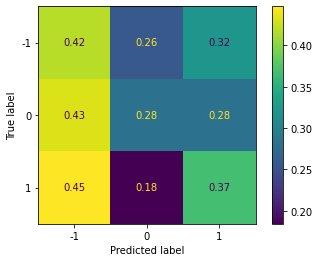

In [35]:
ss1 = StandardScaler()
cls_d = DummyClassifier(strategy='uniform') # We can use other strategies
cls_d.fit(ss1.fit_transform(X.iloc[:split]),y.iloc[:split])
y_predict_d = cls_d.predict(ss1.transform(X.iloc[split:]))

# Plot classification report confusion matrix of dummy
print(classification_report(df['Signal'].iloc[split:], y_predict_d))
plot_confusion_matrix(cls_d,ss1.transform(X.iloc[split:]), df['Signal'].iloc[split:], normalize='true')

Next we see the classification report and confusion matrix of the proposed classifier. It should be better than the dummy classifier:

              precision    recall  f1-score   support

          -1       0.32      0.61      0.42        31
           0       0.57      0.28      0.38        60
           1       0.45      0.47      0.46        38

    accuracy                           0.42       129
   macro avg       0.45      0.46      0.42       129
weighted avg       0.47      0.42      0.41       129



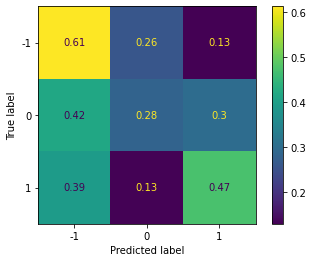

In [36]:
print(classification_report(df['Signal'].iloc[split:], y_predict))
plot_confusion_matrix(cvo,X.iloc[split:], df['Signal'].iloc[split:], normalize='true') 

In [37]:
accuracy_score(y.iloc[split:],y_predict, normalize=True)

0.4186046511627907

### Using the Model For Trading Strategy
* Trading Strategy 
> Our trading strategy is simply to buy/sell/do-nothing at that period for which the Signal is generated by the algorithm. The strategy assumes that you always get a fill at the "Open" prices. 

* lysing the Performance
> Recall, we had calculated and saved returns on 'Open' prices in 'Ret'. We will create a column named Ret1 to store the strategy’s returns based on the Signal. ‘Cu_Ret1’ is initialized to hold cumulative returns of our strategy.  

In [38]:
df['Ret1'] = df['Ret'] * df['Pred_Signal'] 
df['Cu_Ret1'] = 0.

In [39]:
df.head()

,Time,Open,High,Low,Close,Volume,RSI,SMA,SAR,ADX,Corr,close,high,low,OO,OC,Ret,return1,return2,return3,return4,return5,return6,return7,return8,return9,Signal,Pred_Signal,Ret1,Cu_Ret1
20,2021-10-18 09:35:59,317.90,318.20,317.60,317.80,29910,43.095793,318.850,319.184400,13.793519,0.816229,317.90,318.30,317.85,-0.35,0.00,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,-0.000782,0.002035,0.002196,-1,1.0,-0.000315,0.0
21,2021-10-18 09:36:59,317.80,317.85,317.40,317.40,21161,41.910041,318.795,318.917520,15.563131,0.871812,317.80,318.20,317.60,-0.10,0.00,-0.001259,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,-0.000782,0.002035,-1,1.0,-0.001259,0.0
22,2021-10-18 09:37:59,317.40,318.15,317.25,318.00,20039,37.343463,318.630,318.654016,17.581703,0.919286,317.40,317.85,317.40,-0.40,0.00,0.002046,-0.001259,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,-0.000782,1,-1.0,-0.002046,0.0
23,2021-10-18 09:38:59,318.05,318.65,317.85,318.65,20345,46.973248,318.465,318.403213,18.123915,0.892114,318.00,318.15,317.25,0.65,0.05,0.001885,0.002046,-0.001259,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-0.001253,1,0.0,0.000000,0.0
24,2021-10-18 09:39:59,318.65,319.00,318.10,318.25,86988,55.251655,318.380,317.250000,16.790058,0.616495,318.65,318.65,317.85,0.60,0.00,-0.001413,0.001885,0.002046,-0.001259,-0.000315,-0.001100,-0.001884,-0.000314,-0.000157,-0.000157,-1,0.0,-0.000000,0.0


Please note that here only the test data was used to compare the performance of the strategy. We can pass the entire 'Ret1' column and check the performance on both the test and train data.

In [40]:
df['Cu_Ret1'] = np.cumsum(df['Ret1'].iloc[split:])

Now, we will create a column named 'Cu_Ret' to store the cumulative market’s returns for the test data.

In [41]:
df['Cu_Ret'] = 0.
df['Cu_Ret'] = np.cumsum(df['Ret'].iloc[split:])

Next, we will calculate the standard deviation of the cumulative strategy returns, and use it to further to calculate the Sharpe ratio, which is used as a measure for the strategy's performance.

In [42]:
Std = np.std(df['Cu_Ret1'])
Sharpe = (df['Cu_Ret1'].iloc[-1] - df['Cu_Ret'].iloc[-1])/Std # Will not annualize this because the data is intraday data
print('Sharpe Ratio:', Sharpe)

Sharpe Ratio: 3.1866759927987247



Now We can plot the results to visualize the performance.


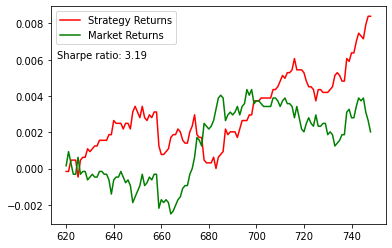

In [43]:
plt.plot(df['Cu_Ret1'], color='r', label='Strategy Returns')
plt.plot(df['Cu_Ret'], color='g', label='Market Returns')
plt.figtext(0.14,0.7,s='Sharpe ratio: %.2f'%Sharpe)
plt.legend(loc='best')
plt.show()

#### Finally lets see what happens when a dummy classifier does the trading

Sharpe Ratio: -2.2446487242119657


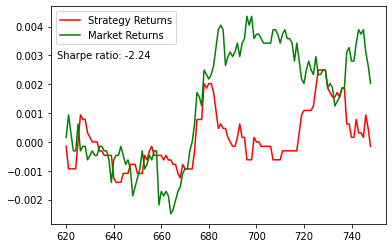

In [44]:
df.iloc[split:, df.columns.get_loc('Pred_Signal')] = y_predict_d
df['Ret1'] = df['Ret'] * df['Pred_Signal'] 
df['Cu_Ret1'] = 0.
df['Cu_Ret1'] = np.cumsum(df['Ret1'].iloc[split:])
df['Cu_Ret'] = 0.
df['Cu_Ret']=  np.cumsum(df['Ret'].iloc[split:])
Std = np.std(df['Cu_Ret1'])
Sharpe = (df['Cu_Ret1'].iloc[-1] - df['Cu_Ret'].iloc[-1])/Std # will not annualize this because the data is intraday data
print('Sharpe Ratio:', Sharpe)
plt.plot(df['Cu_Ret1'], color='r', label='Strategy Returns')
plt.plot(df['Cu_Ret'],color='g', label='Market Returns')
plt.figtext(0.14,0.7, s='Sharpe ratio: %.2f'%Sharpe)
plt.legend(loc='best')
plt.show()